# Normalizing the Muon Background (vz0)

#### Din-Ammar Tolj - Y25
Maruyama Group, Summer 2023

#### CURRENTLY WIP, not checked with Jorge if this is allowed. Don't rely too too much on this for now

In [1]:
import numpy as np

import ROOT
from ROOT import *
from root_numpy import array2hist, hist2array, fill_hist

import sys
import math

import os
import scipy
import pandas as pd
import seaborn as sns

from datetime import datetime
from glob import glob

%cd libs/
from dt5202 import dt5202_crunch # Import parser that Tom wrote. This is containted in the file named dt5202.py in this folder.
from dt5202oldDAQ import dt5202_crunch as dt5202_crunch_oldDAQ # Old ver

from langaus import LanGausFit 
%cd -

import warnings
warnings.filterwarnings("ignore")

Welcome to JupyROOT 6.22/00
/home/coure/Din_SmearingProject_Summer2023/libs
/home/coure/Din_SmearingProject_Summer2023


In [11]:
ped = 50 #pedestal correction

# Declare constants for conversion from ADC to PE/MeV

adc_mev = 538.3933387436877 # from "MuonPeakCalibration_Din_ThanksEmily_v1_cut.ipynb"
pe_mev = 53.95 # gotten from averaging two values from "OLD_MuonsAndGammas_SimulationFitting_Din_v2_w_Caesium.ipynb"

sig662 = 0.159223 # Get the sigma in MeV from "Cs137_GaussFitting_ForResolution_Din_vz1.ipynb"
# sigma_pe = sigma * pe_mev # Convert to PE

sig1pe = (.662*pe_mev) / (sig662*pe_mev) 
# lin_sigma_pe = lin_sigma * pe_mev # Convert to PE

R = 0.07
# gbins = 100 #Bins for each of the gamma lines
hmin = 0.01
hmax = 14
bins = int((hmax-hmin)/R)

In [3]:
folder_m = "muons_edited/muonsInPanel_build/" # location of the muon sim build folder

# Muons
muons = TFile(folder_m + "muonsJ_normalized.root", "READ")

# For the TTree for Muons
a = muons.Get("ntuple")
muonstree = a.Get("parTup")

# Append muons
muonsEnergy = []
for event in muonstree:
    muonsEnergy.append(event.Edeposited)
    
mu_mev = np.array(muonsEnergy) # muons

In [4]:
%%capture

sourceFolder = "/data/board1771_01192023_retestingSwirlyPanel/"

onlyfiles = [f for f in os.listdir(sourceFolder) if '.dat' in f]

data_list = []
for file in onlyfiles:
    data_list.append(dt5202_crunch(str(sourceFolder)+str(file), num_ev=100000000, num_ch=1))

data = data_list[0]
for i in range(1, len(data_list)):
    data = np.append(data, data_list[i])

In [5]:
# Convert lab data to MeV

d = data['data']['low_gain']-ped
lab_mev = (d.astype('float64'))/adc_mev # lab data in MeV

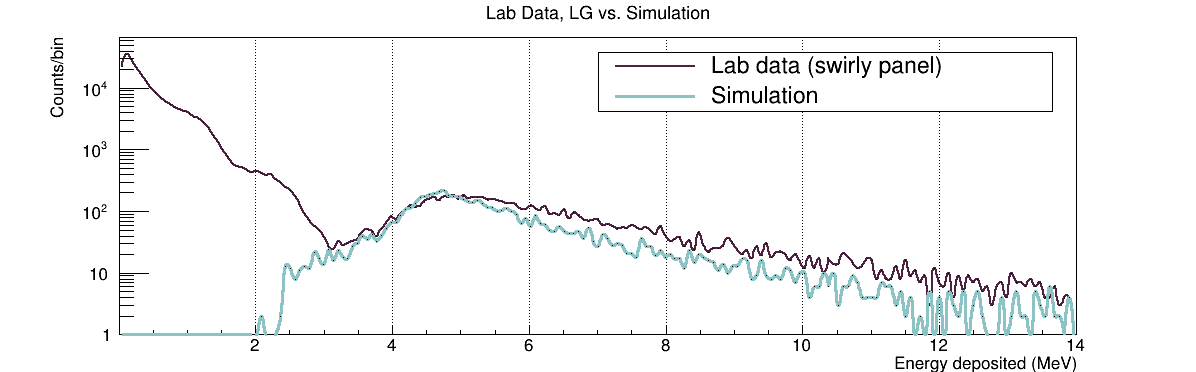

In [6]:
h_dat = TH1F('h_dat','',bins,hmin,hmax)
h_mu = TH1F('h_mu','',bins,hmin,hmax)

fill_hist(h_dat, lab_mev)
fill_hist(h_mu, mu_mev)

h_dat.Sumw2()

c1 = TCanvas('c1','',1200,400)
c1.cd()
gStyle.SetPalette(ROOT.kCandy)

h_dat.Draw("plc pcm hist")
h_dat.SetTitle("Lab Data, LG vs. Simulation")
h_dat.GetXaxis().SetTitle("Energy deposited (MeV)")
h_dat.GetXaxis().SetLabelSize(.05)
h_dat.GetXaxis().SetTitleSize(.05)
h_dat.GetYaxis().SetTitle("Counts/bin")
h_dat.GetYaxis().SetLabelSize(.05)
h_dat.GetYaxis().SetTitleSize(.05)
h_dat.GetYaxis().SetTitleOffset(.65)
h_dat.SetLineWidth(2)

h_mu.Draw("plc pcm same hist")
h_mu.SetLineWidth(3)

gPad.SetLogy()
gPad.SetGridx()
gStyle.SetOptStat(0)

legend3 = TLegend(0.5,0.7,0.88,0.86)
legend3.AddEntry(h_dat,"Lab data (swirly panel)","l")
legend3.AddEntry(h_mu,"Simulation","l")
legend3.Draw()

c1.Draw()

In [7]:
lx = int(3/R)
ux = int(14/R)
dat_int = h_dat.Integral(lx,ux)
int1 = h_mu.Integral(lx,ux)
h_mu.Scale(dat_int/int1)
h_mu.Sumw2()

Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created


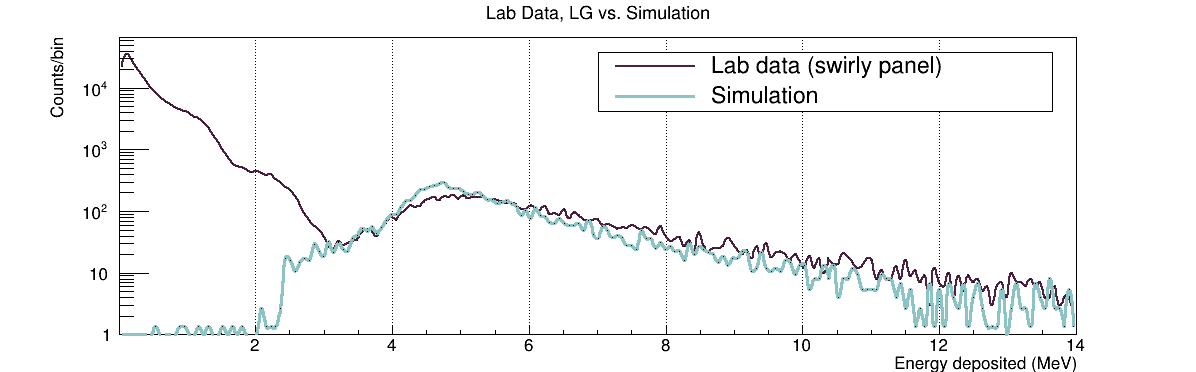

In [8]:
c1.Update()

c1.Draw()

In [9]:
mu_pe = mu_mev * pe_mev

Warning in <TFile::Append>: Replacing existing TH1: h_mu (Potential memory leak).
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


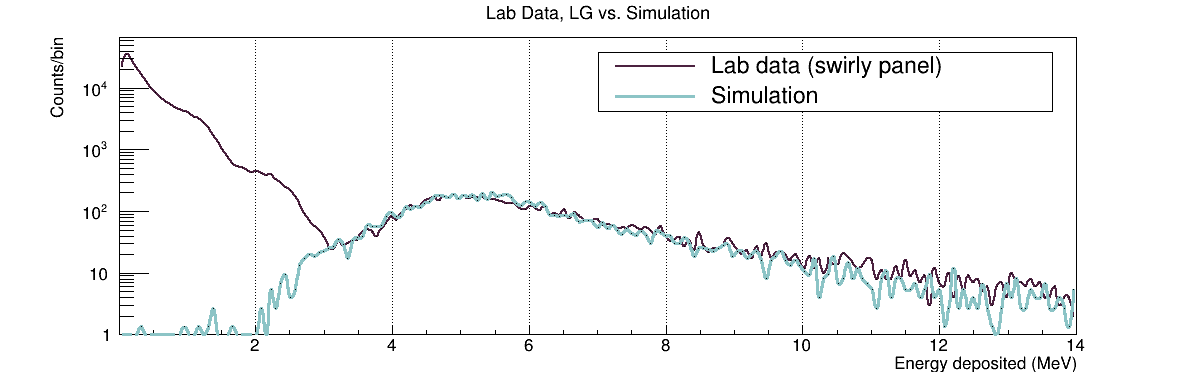

In [13]:
bg_smeared_lin_mu_pe = np.random.normal(loc=mu_pe, scale = np.power(sig1pe * mu_pe, 0.5)) + 17

h_mu = TH1F('h_mu','',bins,hmin,hmax)
fill_hist(h_mu, bg_smeared_lin_mu_pe / pe_mev)

lx = int(3/R)
ux = int(14/R)
dat_int = h_dat.Integral(lx,ux)
int1 = h_mu.Integral(lx,ux)
h_mu.Scale(dat_int/int1)
h_mu.Sumw2()

c2 = TCanvas('c1','',1200,400)
c2.cd()
gStyle.SetPalette(ROOT.kCandy)

h_dat.Draw("plc pcm hist")

h_mu.Draw("plc pcm same hist")
h_mu.SetLineWidth(3)

gPad.SetLogy()
gPad.SetGridx()
gStyle.SetOptStat(0)

legend = TLegend(0.5,0.7,0.88,0.86)
legend.AddEntry(h_dat,"Lab data (swirly panel)","l")
legend.AddEntry(h_mu,"Simulation","l")
legend.Draw()

c2.Draw()